# Pós-Graduação em Ciência de Dados e Analytics - PUC-Rio

## MVP - Machine Learning & Analytics
###  **Parte II: Deep Learning**

### Aluno: Fabiano Ramos (Julho / 2023)



## Definição do Problema

Para este trabalho, decidimos abordar um problema de multiclassificação de imagens. O *dataset* escolhido foi o [Pokemon Classification](https://huggingface.co/datasets/keremberke/pokemon-classification), disponibilizado através do *site* [HuggingFace](https://huggingface.co/).

O conjunto de dados consiste em aproximadamente 7000 imagens contemplando 150 *pokémons* distintos. Cada *pokémon* se encontra representado entre 35 e 65 vezes (aprox. 45 em média). Cada imagem possui resolução de 224x244 *pixels*, no formato de cores RGB.


Inicialmente, realizamos a preparação do ambiente, desabilitando alguns *warnings*, verificando a presença de GPUs (fortemente recomendado para a execução deste *noteboook*) e instalando o pacote *gdown* para a obtenção do conjunto de dados.  Realizamos também a importação das bibliotecas necessárias.

In [ ]:
# desabilita warnings di python
import warnings
warnings.filterwarnings("ignore")

# desabilita warnings do tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# verifica os recursos de hardware
import tensorflow as tf
print(f'GPUs: {len(tf.config.list_physical_devices("GPU"))}')
print(f'CPUs: {len(tf.config.list_physical_devices("CPU"))}')

GPUs: 1
CPUs: 1


In [ ]:
# pacotes a serem instalados
!pip install gdown

In [ ]:
# imports
import random
import datetime
import pandas as pd
import numpy as np
import gdown
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# random seed
random_seed = 42
np.random.seed(random_seed)


## Carga dos Dados

Realizamos então a carga do *dataset*.

O conjunto de dados se encontrava divido em três pacotes *zip*, pré-separados em treinamento, validação e teste.

A carga consistiu então em baixar os três pacotes e descompactá-los localmente.

Destacamos que o conjunto de dados também pode ser acessado diretamente via API do *huggingface*, mas optamos por baixá-lo no sentido de manter o trabalho auto-contido e o *notebook* passível de ser executado em momento arbitrário no futuro.

In [ ]:
# diretorios locais
dataset_local_folder = './datasets/pokemon/'
images_local_folder = './images/pokemon/'
model_local_folder = './models/pokemon/'

os.makedirs(dataset_local_folder, exist_ok=True)
os.makedirs(images_local_folder, exist_ok=True)
os.makedirs(model_local_folder, exist_ok=True)

# paths remotos
url_base = "https://raw.githubusercontent.com/pragmaerror/puc-ciencia-de-dados-e-analytics/main/machine-learning-analytics/mvp/data/"
set_list = ['train', 'valid', 'test']

# baixa zips
for f in set_list:
    f = f + '.zip'
    if (not os.path.isfile(dataset_local_folder + f)):
        print(f'Downloading {url_base + f}')
        gdown.download(url_base + f, dataset_local_folder + f)
    else:
        print(f'Usando dataset existente {f}: {dataset_local_folder + f}')

# expande zips
for f in set_list:
    destination_folder =  images_local_folder + f
    os.makedirs(destination_folder, exist_ok=True)
    f = f + '.zip'
    print(f'Extraindo {dataset_local_folder + f} => {destination_folder}')
    with zipfile.ZipFile(dataset_local_folder + f,'r') as z:
        z.extractall(destination_folder)
        total_files = 0
        result = next(os.walk(destination_folder))
        for d in  result[1]:
            total_files += len(os.listdir(destination_folder + '/'+ d))
        print(f'\t{total_files} imagens de {len(os.listdir(destination_folder))} classes diferentes.')

Usando dataset existente train.zip: ./datasets/pokemon/train.zip
Usando dataset existente valid.zip: ./datasets/pokemon/valid.zip
Usando dataset existente test.zip: ./datasets/pokemon/test.zip
Extraindo ./datasets/pokemon/train.zip => ./images/pokemon/train
	4869 imagens de 110 classes diferentes.
Extraindo ./datasets/pokemon/valid.zip => ./images/pokemon/valid
	1390 imagens de 35 classes diferentes.
Extraindo ./datasets/pokemon/test.zip => ./images/pokemon/test
	732 imagens de 21 classes diferentes.


Em seguida, definimos algumas informações complementares sobre o conjunto de dados, incluindo o nome das 150 classes e as dimensões das imagens.

In [ ]:
# informações do dataset
class_names = ['Porygon', 'Goldeen', 'Hitmonlee', 'Hitmonchan', 'Gloom', 'Aerodactyl', 'Mankey', 'Seadra', 'Gengar', 'Venonat', 'Articuno',
               'Seaking', 'Dugtrio', 'Machop', 'Jynx', 'Oddish', 'Dodrio', 'Dragonair', 'Weedle', 'Golduck', 'Flareon', 'Krabby', 'Parasect',
               'Ninetales', 'Nidoqueen', 'Kabutops', 'Drowzee', 'Caterpie', 'Jigglypuff', 'Machamp', 'Clefairy', 'Kangaskhan', 'Dragonite',
               'Weepinbell', 'Fearow', 'Bellsprout', 'Grimer', 'Nidorina', 'Staryu', 'Horsea', 'Electabuzz', 'Dratini', 'Machoke', 'Magnemite',
               'Squirtle', 'Gyarados', 'Pidgeot', 'Bulbasaur', 'Nidoking', 'Golem', 'Dewgong', 'Moltres', 'Zapdos', 'Poliwrath', 'Vulpix',
               'Beedrill', 'Charmander', 'Abra', 'Zubat', 'Golbat', 'Wigglytuff', 'Charizard', 'Slowpoke', 'Poliwag', 'Tentacruel',
               'Rhyhorn', 'Onix', 'Butterfree', 'Exeggcute', 'Sandslash', 'Pinsir', 'Rattata', 'Growlithe', 'Haunter', 'Pidgey', 'Ditto',
               'Farfetchd', 'Pikachu', 'Raticate', 'Wartortle', 'Vaporeon', 'Cloyster', 'Hypno', 'Arbok', 'Metapod', 'Tangela', 'Kingler',
               'Exeggutor', 'Kadabra', 'Seel', 'Voltorb', 'Chansey', 'Venomoth', 'Ponyta', 'Vileplume', 'Koffing', 'Blastoise', 'Tentacool',
               'Lickitung', 'Paras', 'Clefable', 'Cubone', 'Marowak', 'Nidorino', 'Jolteon', 'Muk', 'Magikarp', 'Slowbro', 'Tauros', 'Kabuto',
               'Spearow', 'Sandshrew', 'Eevee', 'Kakuna', 'Omastar', 'Ekans', 'Geodude', 'Magmar', 'Snorlax', 'Meowth', 'Pidgeotto', 'Venusaur',
               'Persian', 'Rhydon', 'Starmie', 'Charmeleon', 'Lapras', 'Alakazam', 'Graveler', 'Psyduck', 'Rapidash', 'Doduo', 'Magneton',
               'Arcanine', 'Electrode', 'Omanyte', 'Poliwhirl', 'Mew', 'Alolan Sandslash', 'Mewtwo', 'Weezing', 'Gastly', 'Victreebel',
               'Ivysaur', 'MrMime', 'Shellder', 'Scyther', 'Diglett', 'Primeape', 'Raichu']
number_of_classes = len(class_names)
images_width = 224
images_height = 224
image_colors = 255

## Preparação dos dados


Após a descompactação dos arquivos, realizamos uma inspeção das imagens.

Conforme já mencionado, o conjunto de dados se encontrava pré-separado em treinamento, validação e teste.

No entanto, verificamos que esta divisão havia sido realizada de forma pouco criteriosa:

 * **treino**:	4869 imagens de 110 classes diferentes.
 * **validação**:	1390 imagens de 35 classes diferentes.
 * **teste**:	732 imagens de 21 classes diferentes.

Em primeiro lugar, notamos que nenhum dos conjuntos capturava as 150 classes em sua totalidade. Em segundo lugar, existiam classes representadas somente no conjunto de validação e/ou teste, não estando presentes no conjunto de treinamento.

Dedicimos então reunir todas em imagens em um único grupo, e realizar novamente a divisão dos conjuntos, desta vez de forma estratificada com o objetivo de proporcionar um adequado treinamento e teste do modelo.

In [ ]:
def prepare_dataframe() :
    images = []
    labels = []
    for f in set_list:
        set_folder = images_local_folder + f
        pokemon_dirs = next(os.walk(set_folder))
        for d in  pokemon_dirs[1]:
            pokemon_label = d
            assert(pokemon_label in class_names)
            pokemon_folder = set_folder + '/'+ d + '/'
            pokemon_images = os.listdir(pokemon_folder)
            for i in pokemon_images:
                image_path = pokemon_folder + '/' + i
                assert(os.path.isfile(image_path))
                images.append(image_path)
                labels.append(pokemon_label)
    return pd.DataFrame({'images': images, 'labels': labels})

# prepara os dataframe único
full_data_df = prepare_dataframe()
print(full_data_df)

                                                 images     labels
0     ./images/pokemon/train/Kabutops//e8e660951a6a4...   Kabutops
1     ./images/pokemon/train/Kabutops//276a2f970c0d4...   Kabutops
2     ./images/pokemon/train/Kabutops//c00d441169164...   Kabutops
3     ./images/pokemon/train/Kabutops//f9d458ee66234...   Kabutops
4     ./images/pokemon/train/Kabutops//cbdc0cbd79c94...   Kabutops
...                                                 ...        ...
6986  ./images/pokemon/test/Alakazam//972631f1ee1245...   Alakazam
6987  ./images/pokemon/test/Alakazam//601729d8dcd84c...   Alakazam
6988  ./images/pokemon/test/Poliwrath//tumblr_ndmwn1...  Poliwrath
6989  ./images/pokemon/test/Poliwrath//edb3960ab3c59...  Poliwrath
6990  ./images/pokemon/test/Poliwrath//pokemon-poliw...  Poliwrath

[6991 rows x 2 columns]


Uma rápida olhada no histograma do conjunto único dados mostra que o problema de balanceamento foi consideravelmente minimizado.

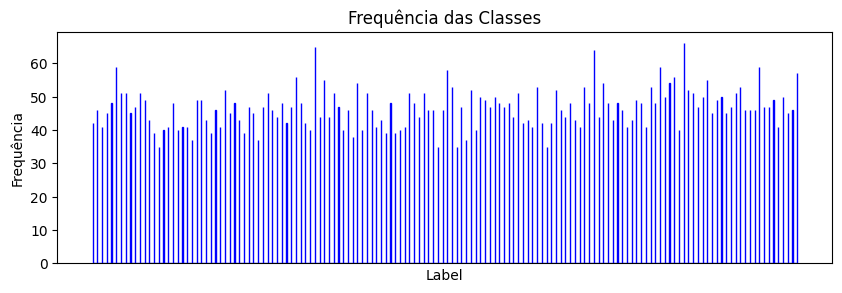

In [ ]:
plt.figure(figsize=[10,3])
plt.hist(full_data_df['labels'], len(full_data_df['labels']), edgecolor='blue')
plt.xlabel('Label')
plt.ylabel('Frequência')
plt.title('Frequência das Classes')
plt.xticks([], [])
plt.show()

### Pré-Processamento


Exibimos a seguir alguns registros aletórios de cada subconjunto de dados.

Aproveitamos também para verificar que as dimensões das imagens seguiam a especificação informada (224x224).

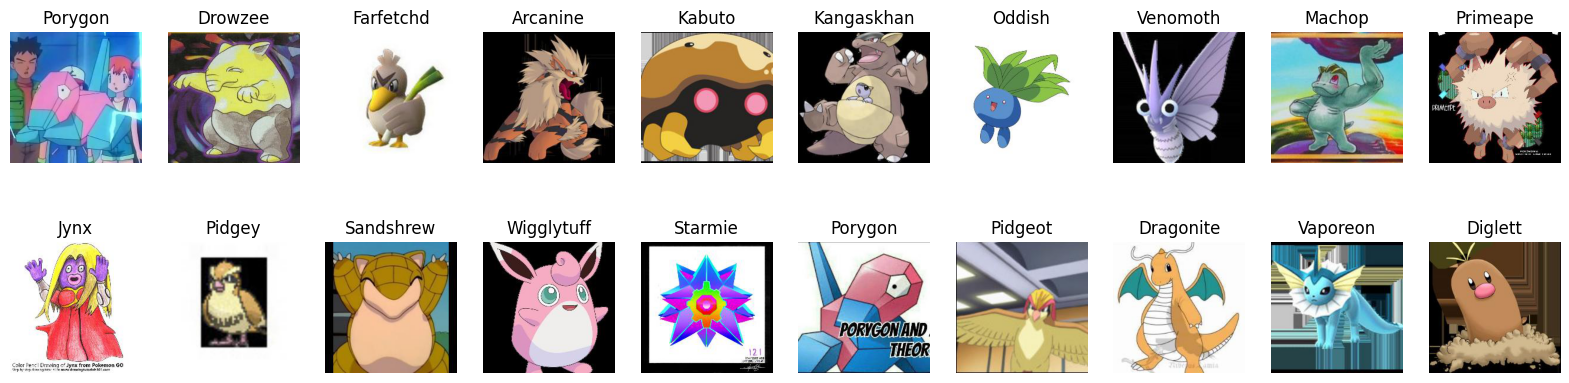

In [ ]:
def show_random_images(df):
    nrows = 2
    ncols = 10
    fig = plt.gcf()
    fig.set_size_inches(20,5)
    for i in range(nrows*ncols):
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off')
      example = df.sample()
      file_path = example.iloc[0]['images']
      label = example.iloc[0]['labels']
      plt.title(label)
      image = mpimg.imread(file_path)
      assert(images_height == image.shape[0])
      assert(images_width == image.shape[1])
      plt.imshow(image)
    plt.show()

# exibe imagens aleatórias
show_random_images(full_data_df)


### Separação em conjunto de treino, validação e teste



Prosseguimos então para a nova separação do *dataset* em conjuntos de treinamento, validação e teste, de forma estratificada.

Primeiro particionamos o conjunto de dados em treinamento/teste segundo a proporção 75/25. A seguir, do conjunto de treinamento, subtraímos o conjunto de validação segundo a proporção 80/20.

In [ ]:
test_size = 0.25           # tamanho da partição de teste  (em relação ao todo)
validation_size = 0.20     # tamanho da partição de validação (em relação a particao de treino)


# separa a partição de teste
train_df, test_df = train_test_split(full_data_df, test_size=test_size, shuffle=True, random_state=random_seed, stratify=full_data_df['labels'])

# re-divide a partição de treino, separando a partição de validação
train_df, validation_df = train_test_split(train_df, test_size=validation_size, shuffle=True, random_state=random_seed, stratify=train_df['labels'])

Observamos então que todos os conjuntos estavam completos (todas as classes representadas) e razoavelmente balanceados.

Treino:    Imagens: 4194  Classes: 150
Validação: Imagens: 1049  Classes: 150
Teste:     Imagens: 1748  Classes: 150


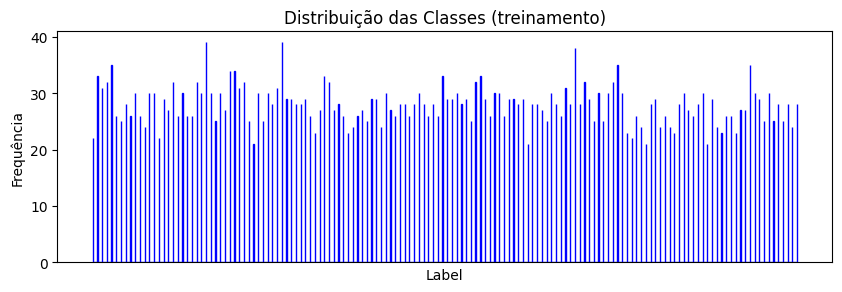

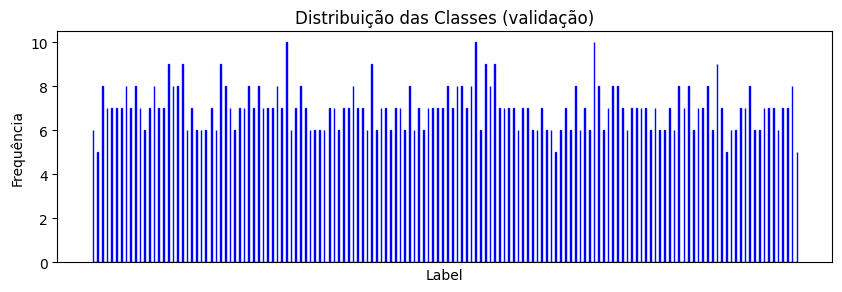

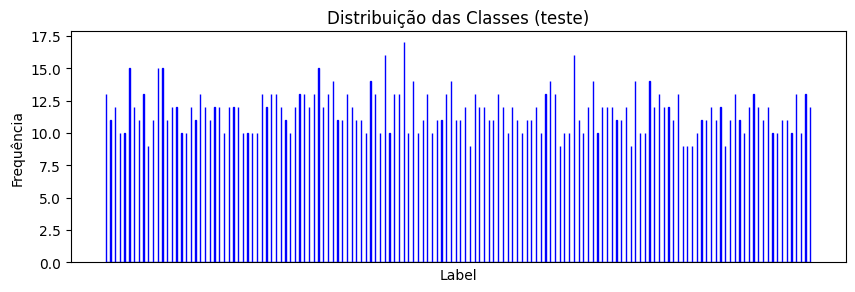

In [ ]:
# resumo
print(f'Treino:    Imagens: {len(train_df)}  Classes: {len(train_df.labels.unique())}')
print(f'Validação: Imagens: {len(validation_df)}  Classes: {len(validation_df.labels.unique())}')
print(f'Teste:     Imagens: {len(test_df)}  Classes: {len(test_df.labels.unique())}')

# historgramas
for key, df in {'treinamento' : train_df, 'validação' : validation_df, 'teste': test_df}.items():
    plt.figure(figsize=[10,3])
    plt.hist(df['labels'], len(df['labels']), edgecolor='blue')
    plt.xlabel('Label')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição das Classes ({key})')
    plt.xticks([], [])
    plt.show()

Como passo seguinte, configuramos então os *geradores*, responsáveis pelo ajuste de escala das informações de cores, além de operações de aumentação do conjunto de imagens de entrada. Através do uso dos geradores, estas operações são realizadas *on-the-fly*.

Este processo se mostrou extramamente valioso para incrementar o conjunto de treinamento, exercendo papel fundamental para redução de *overfitting* durante a etapa de treinamento.

Adicionalmente, no contexto deste trabalho, decidimos reduzir o tamanho das imagens para 64x64  (um fator de 4 aproximadamente) no sentido de reduzir o tempo de treinamento.

Configuramos explicitamente aqui também o hiperparâmetro *batch_size* para 32 (que já é o valor padrão). Este parâmetro é importante pois indica a quatidade de imagens agrupadas para o cálculo em *lotes* da função de custo durante o treinamento. Experimentamos também valores de 64 e 128, mas ambos tiveram um efeito brando, aumentando até ligeiramente o *overfitting*, e desta forma mantivemos o valor de 32.

In [ ]:
images_width = 64
images_height = 64

batch_size = 32

In [ ]:
# gerador de imagens para treinamento
train_datagen = ImageDataGenerator(rescale = 1.0/image_colors,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    None,
    target_size=(images_width,images_height),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    x_col='images',
    y_col='labels',
    shuffle=True,
    random_state=random_seed)

# gerador de imagens para validação
validation_datagen = ImageDataGenerator(rescale=1.0/image_colors)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    None,
    target_size=(images_width,images_height),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    x_col='images',
    y_col='labels',
    shuffle=False)


# gerador de imagens para o conjunto de teste
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1.0/image_colors)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    None,
    target_size=(images_width,images_height),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    x_col='images',
    y_col='labels',
    shuffle=False)


Found 4194 validated image filenames belonging to 150 classes.
Found 1049 validated image filenames belonging to 150 classes.
Found 1748 validated image filenames belonging to 150 classes.


## Modelagem e Treinamento






### Configuração do Modelo


A seguir realizamos a criação e configuração do modelo, uma CNN (*convolutional neural network* ou rede neural de convolução). Tais redes são particularmente úteis no processamento de dados de pixels e são frequentemente utilizadas em tarefas de processamento de imagens.

Tal rede em geral é organizada em três camadas: convolução, subamostragem (*pooling*) e camadas totalmente conectadas (densas). Camadas intermediárias de regularização, normalização e ativação em geral também estão presentes.

Configuramos então nossa rede da seguinte forma: quatro camadas de convolução + subamostragem, seguidas de três camadas densas, após a transformação dos tensores 3D para dados 1D (*Flatten*). Para combater o *overfitting*, inserimos também algumas camadas de regularização (*dropout*).

A última camada (densa) foi configurada usando *softmax* como ativador, apropriado para problemas de multiclassificação. Sua saída também foi configurada de acordo com o número total de classes.

Essa abordagem de configuração é similar ao que se encontra na literatura para problemas similares. Experimentamos com o número de camadas, tamanho do *input*, quantidade e posicionamento de *dropouts* até chegar a configuração aqui descrita.

In [ ]:
# cria o modelo
model = models.Sequential()

# configura o modelo
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(images_width, images_height, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(number_of_classes,activation='softmax'))

# compila o modelo
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

# exibe sumário
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

### Treinamento


Após definido o modelo, seguimos para o treinamento do mesmo.

Configuramos o método *fit* para um número máximo de 50 épocas. Atrávés do uso de *callbacks*, conseguimos um melhor controle do processo de treinamento. Utilizamos três *callbacks*:

 * *Checkpointing*: salva a melhor configuração parcial obtida até então. Ao final do treinamento, o último modelo salvo é então recuperado.

 * *Early Stopping*: interrompe o treinamento antecipadamente caso não haja melhoria na função de custo após 5 iterações.

 * *Learning Rate*: reduz a taxa de aprendizagem caso não haja melhoria da função de custo após 3 iterações.


In [ ]:
checkpoint_file = model_local_folder + '/.checkpoint'

# callbacks
model_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_file, save_weights_only=True, monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', verbose=1)
learning_rate = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=0.00001, verbose=1)

# treina o modelo
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping, learning_rate, model_checkpoint], verbose=1)

# recupera último modelo salvo (ie, o melhor)
model.load_weights(checkpoint_file)

Epoch 1/50
131/132 [============================>.] - ETA: 0s - loss: 5.0086 - accuracy: 0.0106
Epoch 1: val_accuracy improved from -inf to 0.00858, saving model to ./models/pokemon/.checkpoint
132/132 [==============================] - 18s 99ms/step - loss: 5.0078 - accuracy: 0.0105 - val_loss: 4.9993 - val_accuracy: 0.0086 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 4.5890 - accuracy: 0.0253
Epoch 2: val_accuracy improved from 0.00858 to 0.04004, saving model to ./models/pokemon/.checkpoint
132/132 [==============================] - 14s 107ms/step - loss: 4.5890 - accuracy: 0.0253 - val_loss: 4.5504 - val_accuracy: 0.0400 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 4.1379 - accuracy: 0.0665
Epoch 3: val_accuracy improved from 0.04004 to 0.09914, saving model to ./models/pokemon/.checkpoint
132/132 [==============================] - 13s 98ms/step - loss: 4.1379 - accuracy: 0.0665 - val_loss: 3.8506 - val_acc

Em seguida, visualizamos o comportamento da função de custo e acurácia de treinamento e validação. Pudemos notar a ausência de *overfitting*, com as métricas (custo e acurácia) de treinamento e validação bem similares.

<Figure size 2000x500 with 0 Axes>

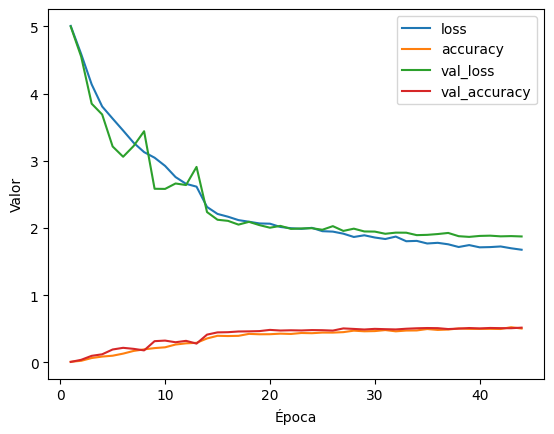

In [ ]:
# nas paradas antecipadas, esse valor é menor do que
# history.params['epochs'], que possui o valor previsto
actual_epochs = len(history.history['loss'])

plt.figure(figsize=[20,5])
epochs_idx = range(1, actual_epochs+1)
history_df = pd.DataFrame(history.history, index=epochs_idx)
history_df = history_df.iloc[:,:4] # exclui coluna 'learning rate'
history_df.plot()
plt.ylabel('Valor')
plt.xlabel('Época')
plt.show()

### Avaliação do Modelo no Conjunto de Teste

O próximo passo foi avaliar o desempenho do modelo sobre o conjunto de teste. Os números são bastante similares aos de validação, indicando mais uma vez que o treinamento foi executado com ausência de *over/under fitting*.


In [ ]:
r = model.evaluate_generator(test_generator)
print("Test: loss = %f  ;  accuracy = %f " % (r[0], r[1]))

Test: loss = 1.843141  ;  accuracy = 0.506865 


### Aplicação do Modelo no Conjunto de Testes

Realizamos em seguida algumas predições utilizando o modelo, com o objetivo de obter mais métricas, como precisão, *recall* e *f1 score*.

In [ ]:
y_true_labels = []
y_pred_labels = []

# total de batches até percorrer o input uma vez
n_batches = int(np.ceil(len(test_df) / batch_size))
curr_batch = 0

for batch in test_generator:
    # print(f'Processando batch {curr_batch+1} de {n_batches}')
    x_batch = batch[0]  # images
    y_batch = batch[1]  # labels
    for i in range(len(y_batch)):
      # realiza a predição
      prediction = model.predict(np.expand_dims(x_batch[i], axis=0), verbose = 0)
      # define como predição a maior probabilidade
      y_pred_labels.append(np.argmax(prediction[0]))
      y_true_labels.append(np.argmax(y_batch[i]))
    curr_batch = curr_batch + 1
    if (curr_batch == n_batches): break

# Calculando as métricas
accuracy = skm.accuracy_score(y_true_labels, y_pred_labels)
precision = skm.precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = skm.recall_score(y_true_labels, y_pred_labels, average='weighted')
f1score = skm.f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Accuracy : ", accuracy)
print("Precision: ", precision)
print("Recall   : ", recall)
print("F1 Score : ", f1score)

Accuracy :  0.5068649885583524
Precision:  0.5217930428218313
Recall   :  0.5068649885583524
F1 Score :  0.4962648558758424


Exibimos também a matriz de confusão, buscando identificar problemas na prediçao de classes específicas.

Como o número de classes é muito grande, decidimos não anotar a matriz, mas observá-la "a distância" como um mapa de calor.

A matriz se mostrou bastante homogênea, indicando um treinamento eficaz.

Text(0.5, 58.7222222222222, 'Label predito')

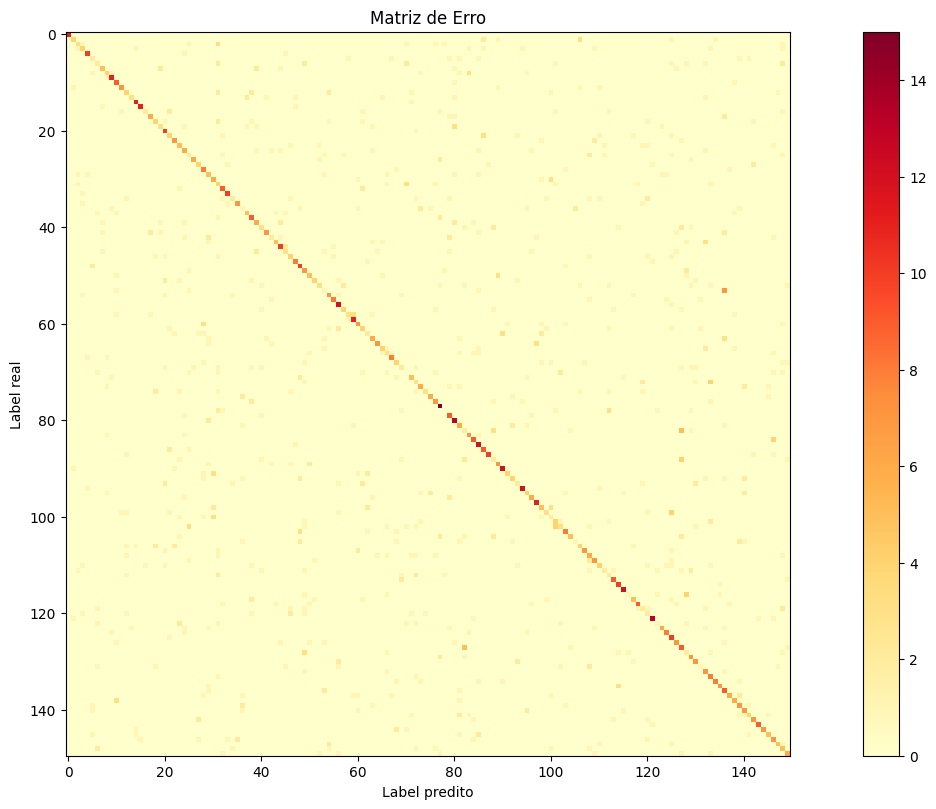

In [ ]:
# calcula a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

# plota a matriz
plt.figure(figsize=(15,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title('Matriz de Erro')
plt.colorbar()
tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names, rotation=90)
#plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('Label real')
plt.xlabel('Label predito')


Complementarmente, exibimos também o relatório de classificação para uma inspeção mais minuciosa.

In [ ]:
# relatório de classificação
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Relatório de Classificação:")
print(classification_rep)

Relatório de Classificação:
                  precision    recall  f1-score   support

         Porygon       1.00      1.00      1.00        11
         Goldeen       0.57      0.33      0.42        12
       Hitmonlee       0.43      0.25      0.32        12
      Hitmonchan       0.40      0.33      0.36        12
           Gloom       0.77      0.83      0.80        12
      Aerodactyl       0.25      0.22      0.24         9
          Mankey       0.22      0.14      0.17        14
          Seadra       0.56      0.42      0.48        12
          Gengar       0.44      0.33      0.38        12
         Venonat       0.73      0.92      0.81        12
        Articuno       0.53      0.82      0.64        11
         Seaking       0.78      0.64      0.70        11
         Dugtrio       0.36      0.31      0.33        13
          Machop       0.75      0.30      0.43        10
            Jynx       0.73      0.92      0.81        12
          Oddish       0.92      0.85      

## Finalização do Modelo


### Exportação do Modelo

Exportamos então o modelo para reuso futuro.




In [ ]:
# salva o modelo treinado
model_name = model_local_folder + '/model_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.h5'
model.save(model_name)
print(f'Modelo salvo como \"{model_name}\"')

Modelo salvo como "./models/pokemon//model_20230630-185020.h5"


### Teste do modelo exportado

Para efeito de validação, carregamos e aplicamos o modelo previamente salvo sobre algums imagens do conjunto de testes (1 *lote*).

Aproveitamos para ter um *feel* visual do desempenho do modelo. As classificações corretas são mostradas em verde, enquanto as incorretas são exibidas em vermelho.

In [ ]:
loaded_model = models.load_model(model_name)
print(f'Modelo carregado.')

Modelo carregado.


Processando 1 batch(es).


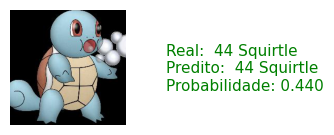

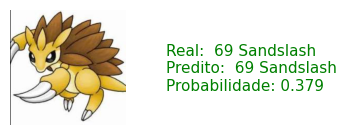

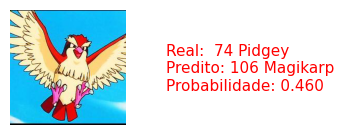

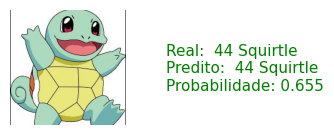

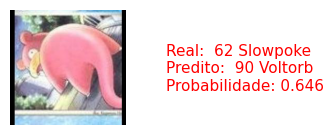

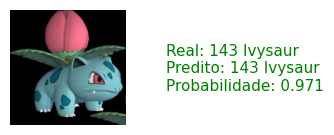

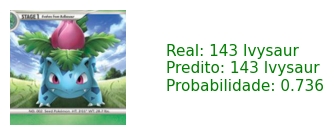

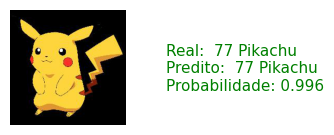

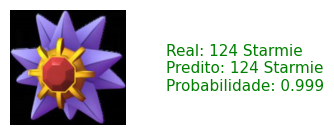

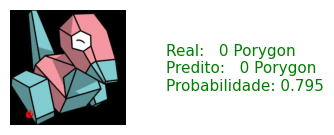

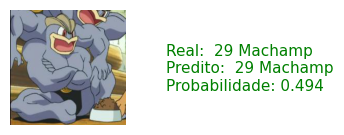

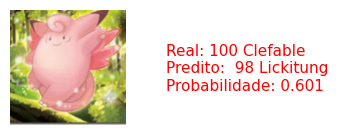

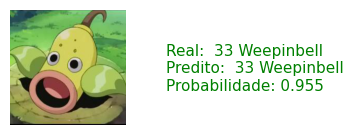

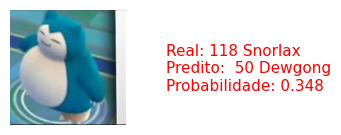

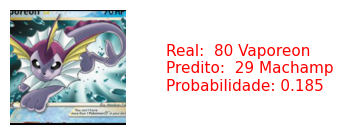

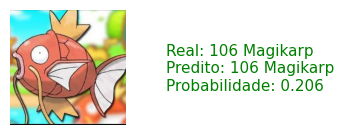

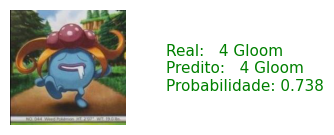

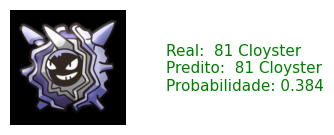

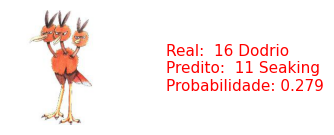

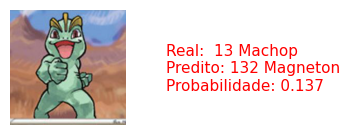

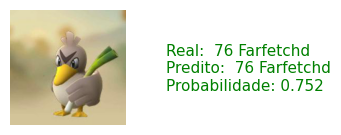

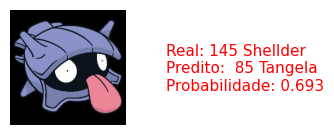

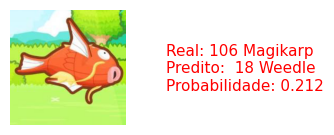

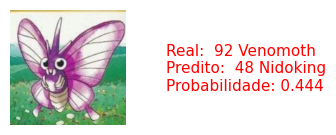

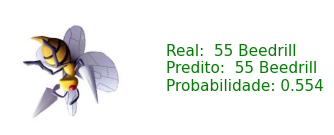

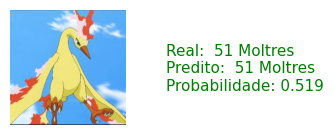

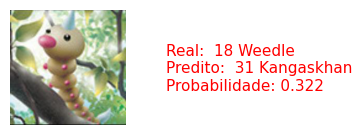

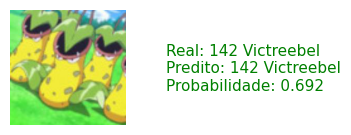

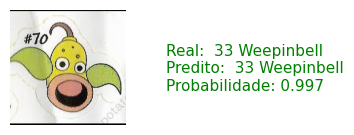

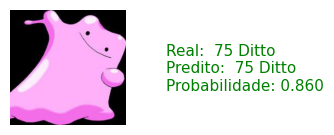

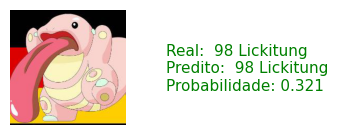

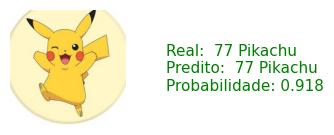

In [ ]:
# total de lotes a processar
n_batches = 1
assert(n_batches <= int(np.ceil(len(test_df) / batch_size)))
print(f'Processando {n_batches} batch(es).')

# indice no test_df
image_idx = 0

curr_batch = 0
test_generator.reset()
for batch in test_generator:
    x_batch = batch[0]  # images
    y_batch = batch[1]  # labels
    for i in range(len(y_batch)):
      # interrompe após ter varrido o dataset (ultimo batch pode ser não exato)
      if (image_idx == len(test_df)): break
      # realiza a predição
      true_class = np.argmax(y_batch[i])
      prediction = loaded_model.predict(np.expand_dims(x_batch[i], axis=0), verbose = 0)
      predicted_class = np.argmax(prediction[0])          # define como predição a maior probabilidade
      probability = prediction[0][predicted_class]
      # exibição
      fig, (ax_image, ax_text) = plt.subplots(1, 2, figsize=(4, 1.5))
      #ax_image.imshow(x_batch[i])                                        # imagem rescaled
      ax_image.imshow(mpimg.imread(test_df.iloc[image_idx]['images']))    # imagem original
      ax_image.axis('off')
      if (predicted_class == true_class):
        color = 'green'
      else:
        color = 'red'
      text = f'Real: {true_class:3d} {class_names[true_class]}\nPredito: {predicted_class:3d} {class_names[predicted_class]}\nProbabilidade: {probability:.3f}'
      ax_text.text(0, 0.3, text, fontsize=11, ha='left', color=color)
      ax_image.axis('off')
      ax_text.axis('off')
      plt.show()
      image_idx = image_idx + 1
    curr_batch = curr_batch + 1
    if (curr_batch == n_batches): break


## Conclusão

As atividades aqui descritas correspondem a nosso primeiro contato com *deep learning* (e com visão computacional).  

Selecionamos então um problema clássico da área, frequentemente utilizado em competições. Embora conhecido, não é um problema de solução trivial , devido à extensa quantidade de classes a serem preditas.

Embora a acurácia do nosso modelo não tenha sido sensacional, acreditamos ter feito um bom trabalho no que se refere ao processo, desde a obtenção/preparação dos dados até o treino, teste e avaliação do modelo.

Conseguimos com sucesso identificar e amenizar o *overfitting*, muito comum neste tipo de projeto. Acreditamos que com mais experiência (e tempo) poderíamos ter configurado nossa rede de forma mais eficiente e obtido melhor acurácia.

